# RESULTS PROCESSOR
For the Master's thesis project

**Author:** Wessel Heerema

**Date:** 21/05/2025

## IMPORTING

In [11]:
import argparse
import pandas as pd
import os
import re
import seaborn as sns

def concat_import(filelist, folder):
    """Import all result files and concatenate them"""
    # Initialize list to concatenate by
    all_dfs = []
    # Iterate and determine columns
    for file in filelist:
        # Load dataframe
        df = pd.read_csv(folder + file)
        # Get file parameters, trim "results" and "csv"
        params = re.findall("[a-z0-9]+", file)[1:-1]
        print(params)
        # Create new columns in the dataframe
        # Determine run type
        if params[0] == "ortho":
            df["Run Type"] = "ortho"
        else:
            df["Run Type"] = "morph"
        # Do the ones that appear in the filename
        df["Constant"] = params[-2]
        df["Seed"] = params[-1]
        # Append to list
        all_dfs.append(df)
    # Concatenate and return
    return pd.concat(all_dfs).reset_index()

# Import everything
folder = "results/"
df = concat_import(os.listdir(folder), folder)
# Convert epochs
dfm = df.melt(id_vars=["ID", "Run Type", "Constant", "Seed"], value_vars=["Val-0", "Val-1", "Val-2", "Val-3", "Val-4"],
              var_name="Epoch", value_name="Perplexity")

['di', '36']
['mono', '1647']
['ortho', 'fus', '1647']
['ortho', 'ana', '1647']
['ortho', 'agg', '1647']
['di', '2016']
['mono', '2016']
['ortho', 'agg', '36']
['ortho', 'fus', '36']
['ortho', 'ana', '36']
['ortho', 'ana', '2016']
['di', '1647']
['ortho', 'agg', '2016']
['mono', '36']
['ortho', 'fus', '2016']


In [12]:
dfm

,ID,Run Type,Constant,Seed,Epoch,Perplexity
0,0,morph,di,36,Val-0,1.468888
1,1,morph,di,36,Val-0,1.850221
2,2,morph,di,36,Val-0,2.007723
3,3,morph,di,36,Val-0,1.959413
4,4,morph,di,36,Val-0,1.591846
...,...,...,...,...,...,...
2215,orth-holland,ortho,fus,2016,Val-4,1.006327
2216,orth-iqglic,ortho,fus,2016,Val-4,1.005948
2217,orth-klingon,ortho,fus,2016,Val-4,1.009475
2218,orth-mono,ortho,fus,2016,Val-4,1.008188


In [18]:
import matplotlib.pyplot as plt

## MORPHOLOGY RUN - RESULTS

<AxesSubplot:xlabel='Epoch', ylabel='Perplexity'>

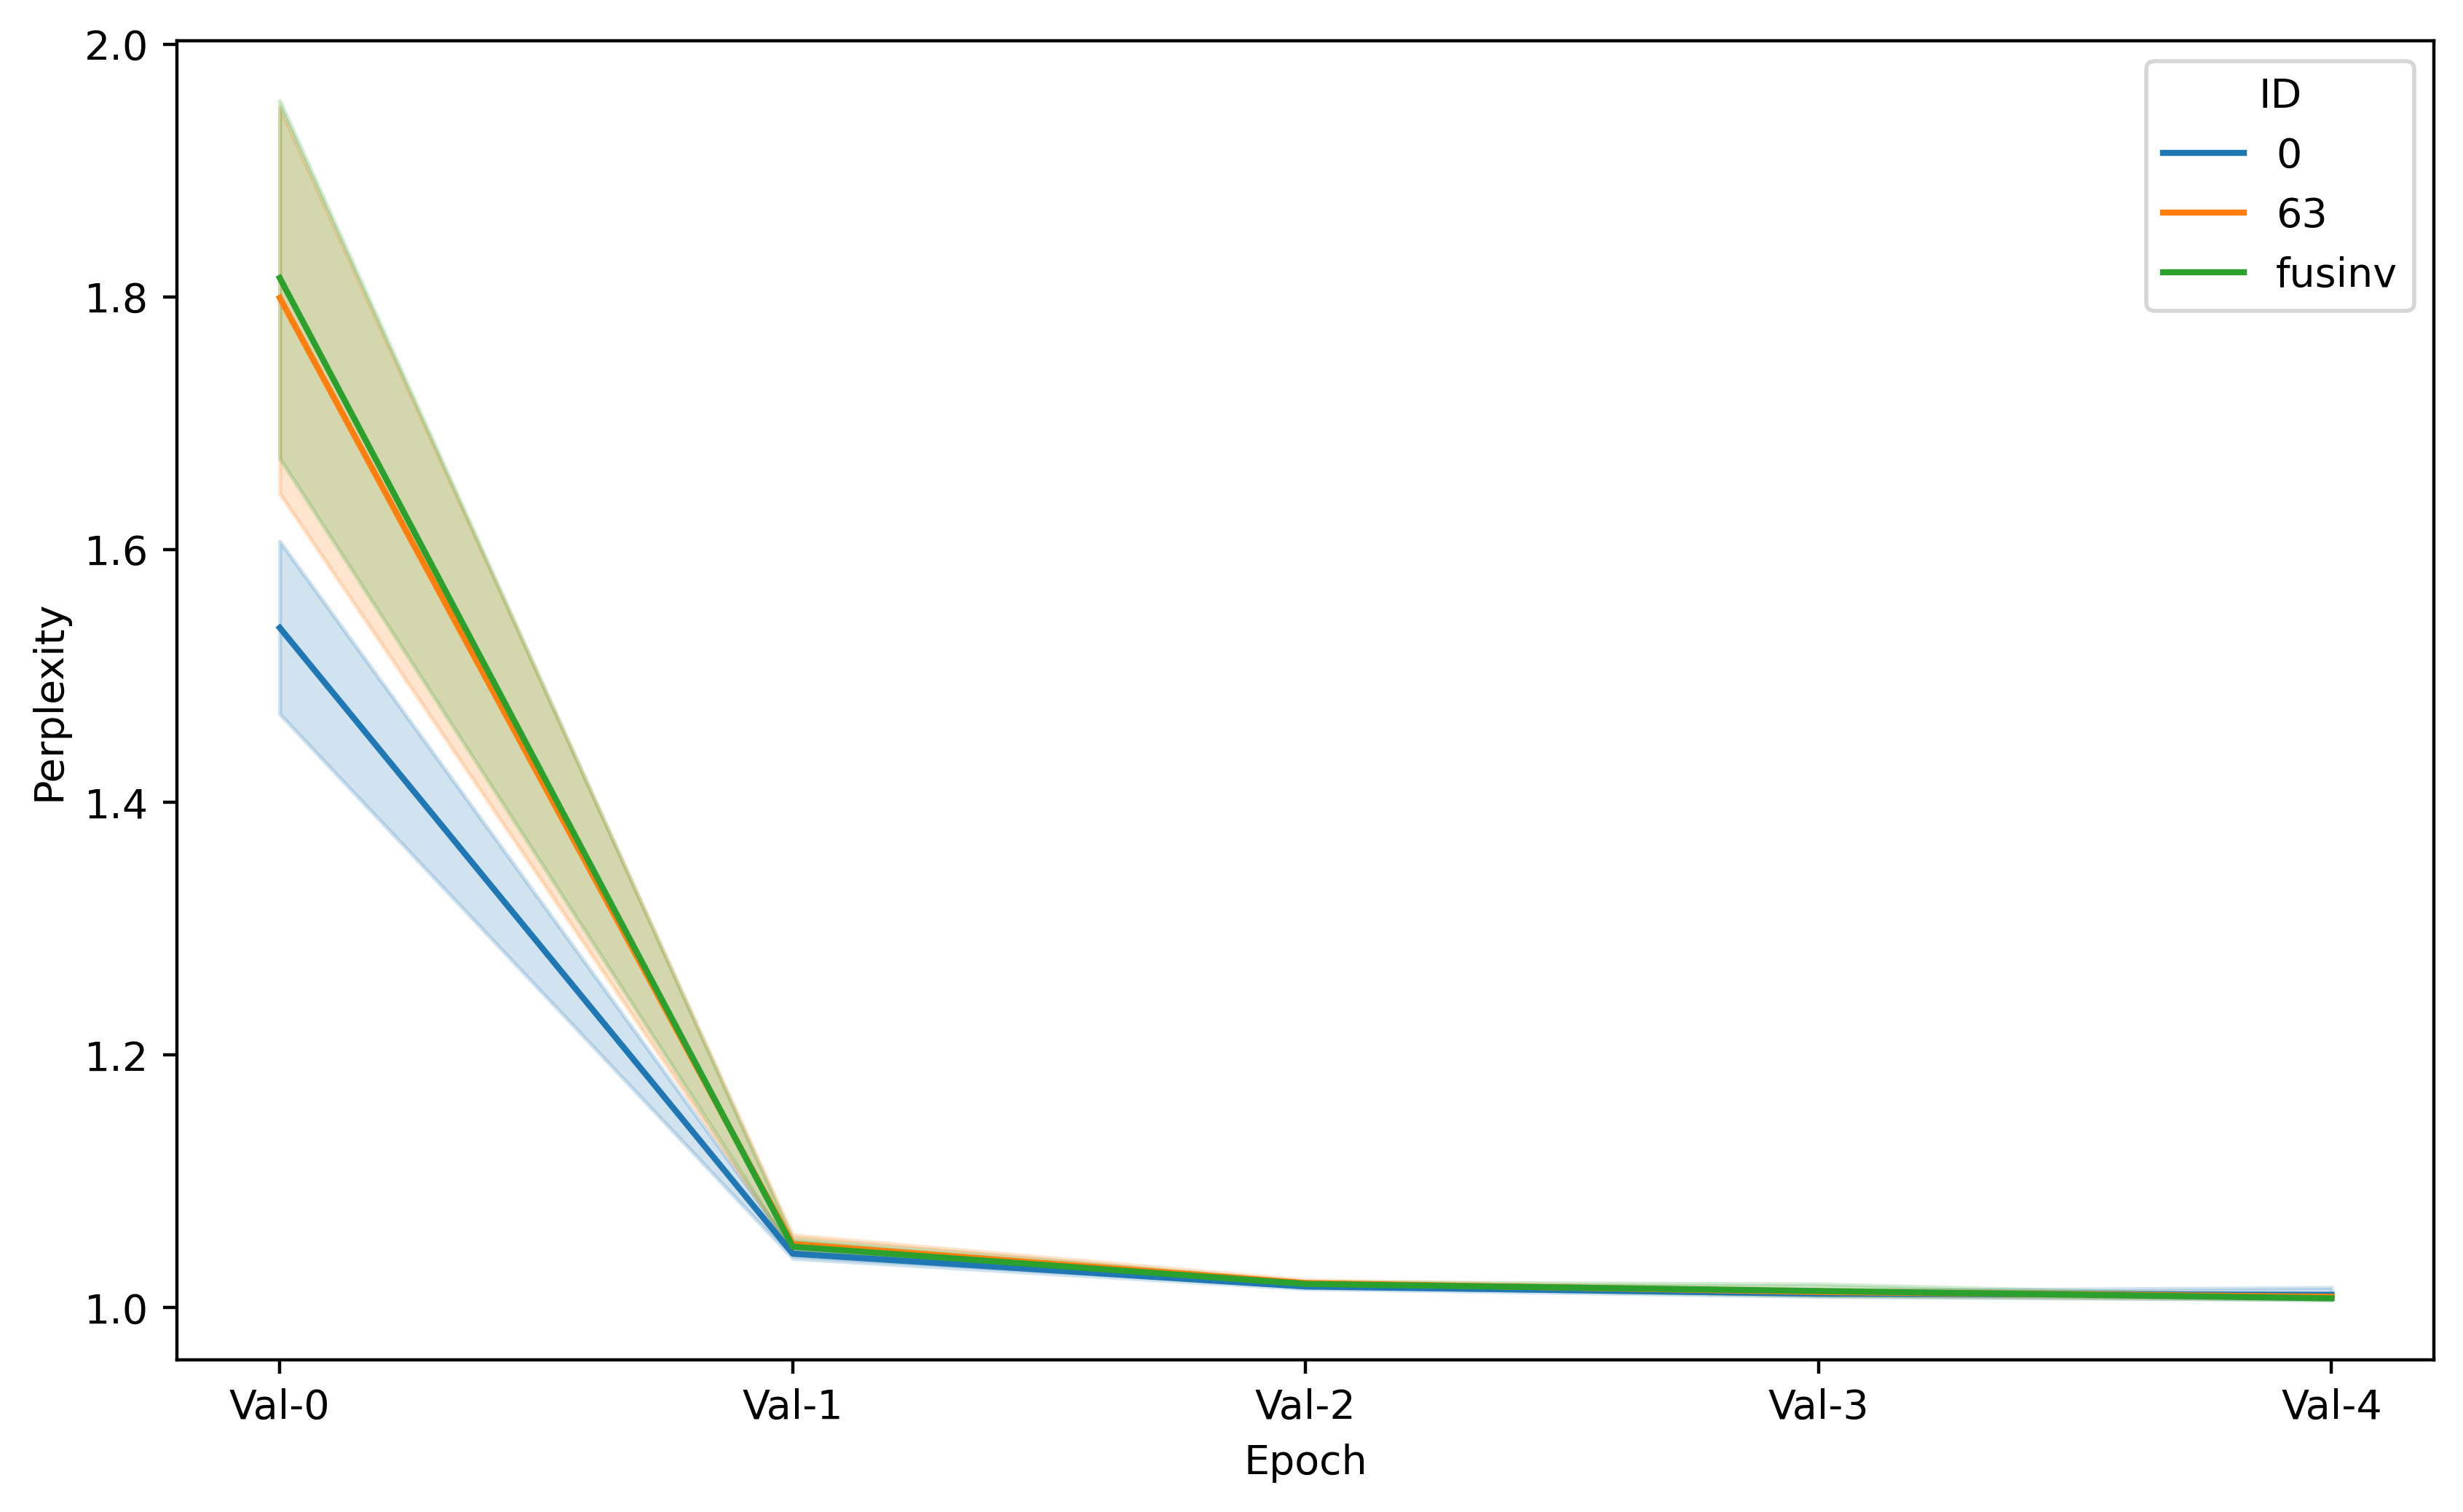

In [20]:
# All three full grammars
df_morph = dfm[(dfm["Run Type"] == "morph") & (dfm["ID"].isin(["0", "63", "fusinv"]))]
plt.figure(figsize=(10, 6), dpi = 400) 
sns.lineplot(data=df_morph, x="Epoch", y="Perplexity", hue="ID")

<Figure size 4000x2400 with 0 Axes>

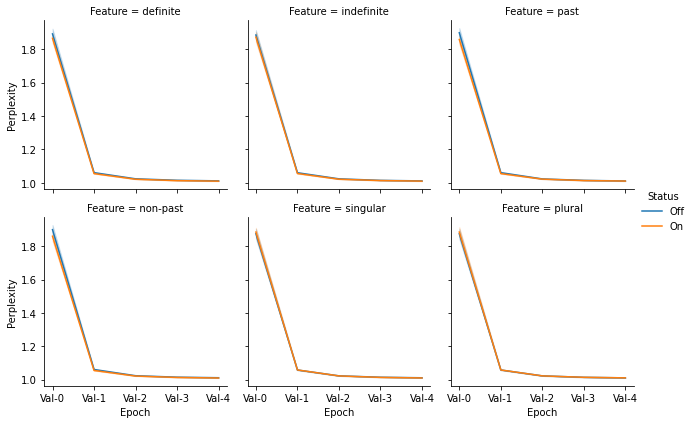

In [60]:
# Series of dropout plots for every switch
df_template = dfm[dfm["Run Type"] == "morph"]
for i, feat in enumerate(["definite", "indefinite", "past", "non-past", "singular", "plural"]):
    # Initialize for appending
    df_appendable = df_template.copy()
    df_appendable["Feature"] = feat
    df_appendable["Status"] = "Off"
    for j in range(64):
        if "{0:06b}".format(j)[i] == "1":
            df_appendable.loc[df_appendable["ID"] == str(j), "Status"] = "On"
    if i == 0:
        df_dropout = df_appendable
    else:
        df_dropout = pd.concat([df_dropout, df_appendable])

# Plot
plt.figure(figsize=(10, 6), dpi = 400) 
g = sns.FacetGrid(data=df_dropout, col="Feature", hue="Status", col_wrap=3)
g.map(sns.lineplot, "Epoch", "Perplexity")
g.add_legend()

## ORTHOGRAPHY RUN - RESULTS

<AxesSubplot:xlabel='Epoch', ylabel='Perplexity'>

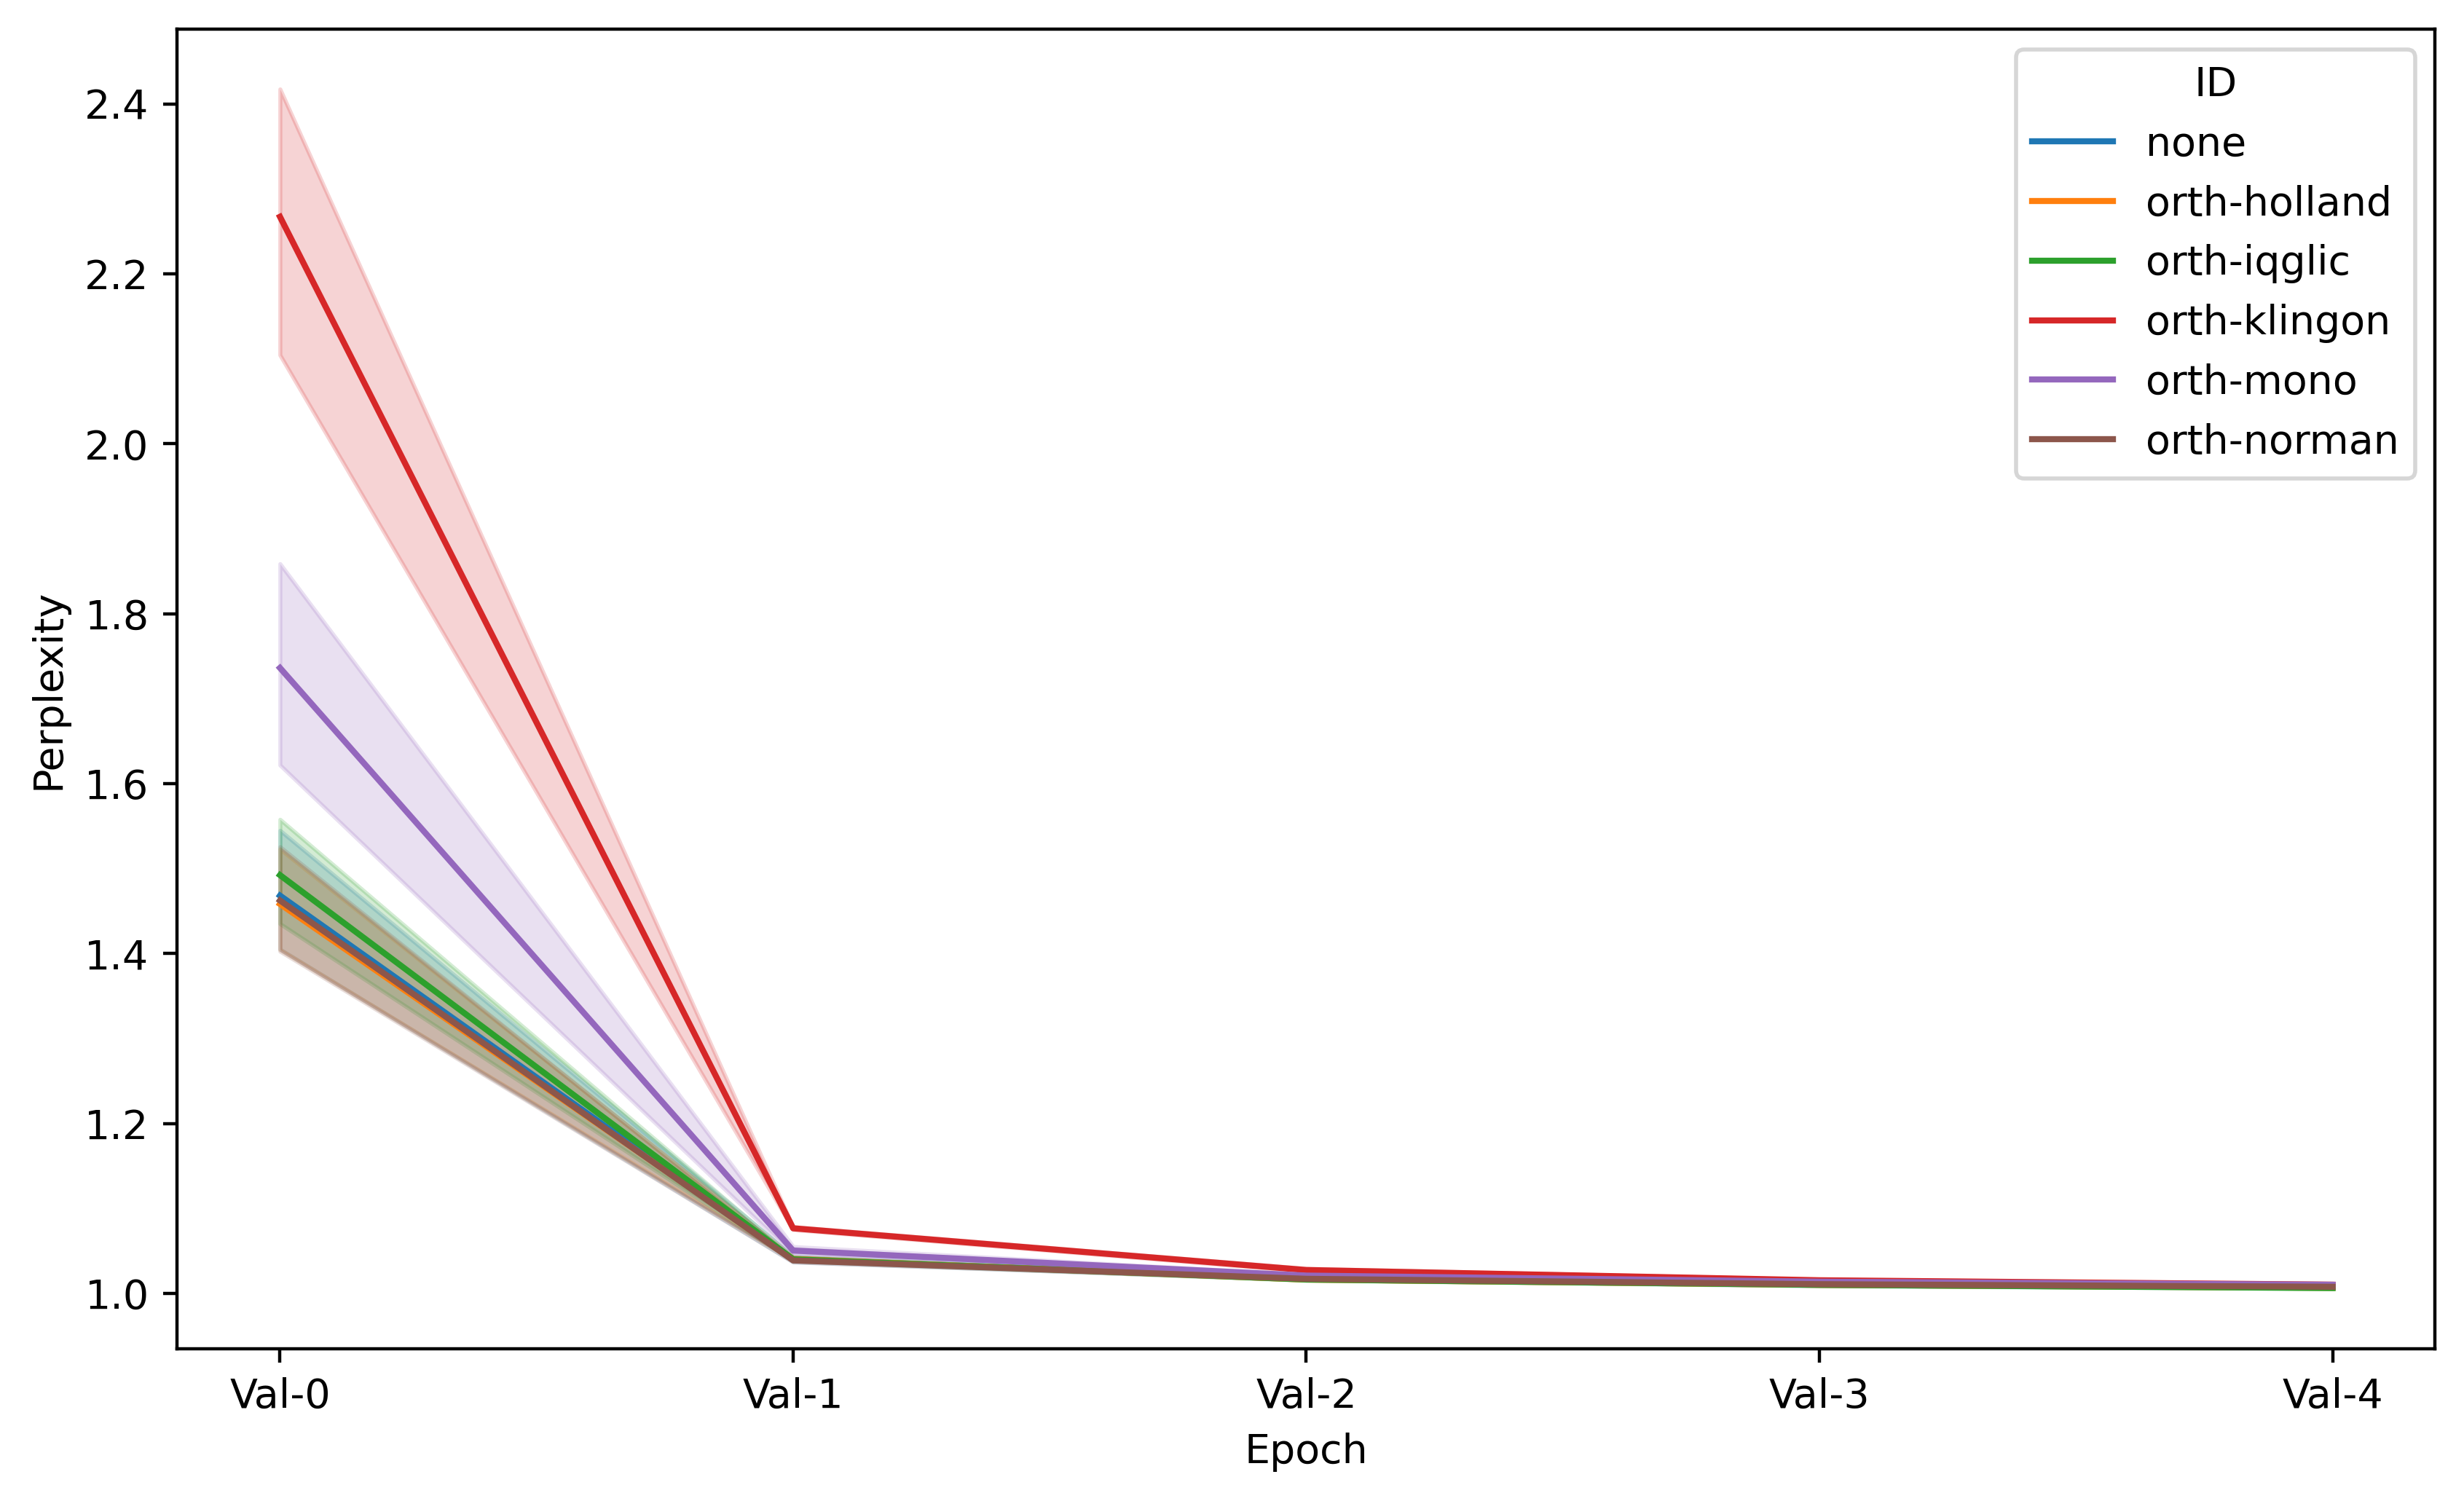

In [61]:
df_morph = dfm[dfm["Run Type"] == "ortho"]
plt.figure(figsize=(10, 6), dpi = 400) 
sns.lineplot(data=df_morph, x="Epoch", y="Perplexity", hue="ID")